### 预训练网络

主要有两种方法：

- 特征提取
- 微调模型

这里使用VGG16模型，而它也是内置于Keras中的，我们可以从`keras.applications`模块导入。此外，它还有:

- `Xception`
- `Inception V3`
- `ResNet50`
- `VGG16`
- `VGG19`
- `MobileNet`

等模型，都在ImageNet数据集上进行过预训练。


In [2]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

### 参数解读

- weights: 指定模型初始化的权重检查点
- include_top: 指定模型最后是否包含全连接层分类器
- input_shape: 输入到网络中的图像张量的形状，参数可选，如果不指定，则可以处理任意形状的输入

In [3]:
# 展示网络的结构
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

可以看出，最后的输出特征图的形状是(4,4,512)，现在我们在这个基础上添加全连接层。现在有两种方式可选：

- 在自己的数据集上运行卷积基，将输出保存在硬盘上，然后用这个数据作为输入，输入到独立的全连接层分类器。这种方法速度快，代价低，但是不允许使用数据增强。
- 在卷积基的顶部添加Dense层来扩展已有模型，输入数据端到端运行整个模型，可以使用数据增强，但是计算代价更高。


In [ ]:
# import
# conv_base.predict(np.ones(shape=(1,150, 150, 3)))

In [9]:
# 使用预训练模型的卷积基提取特征
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 3

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=sample_count)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size:(i+1) *batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
# 将卷积基的输出展平
train_features = np.reshape(train_features, (2000,4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features,(1000, 4 * 4 * 512))

# 定义自己的全连接分类器
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels)
                   )


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 858us/step - loss: 0.6062 - acc: 0.6700 - val_loss: 0.4414 - val_acc: 0.8350
Epoch 2/30
2000/2000 [==============================] - 1s 341us/step - loss: 0.4423 - acc: 0.7910 - val_loss: 0.3629 - val_acc: 0.8600
Epoch 3/30
2000/2000 [==============================] - 1s 417us/step - loss: 0.3621 - acc: 0.8405 - val_loss: 0.3225 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 1s 366us/step - loss: 0.3155 - acc: 0.8760 - val_loss: 0.3013 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 1s 353us/step - loss: 0.2878 - acc: 0.8885 - val_loss: 0.2877 - val_acc: 0.8850
Epoch 6/30
2000/2000 [==============================] - 1s 423us/step - loss: 0.2652 - acc: 0.8945 - val_loss: 0.2715 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 1s 345us/step - loss: 0.2469 - acc: 0.9110 - val_loss: 0.2631 - val_acc: 0.8990


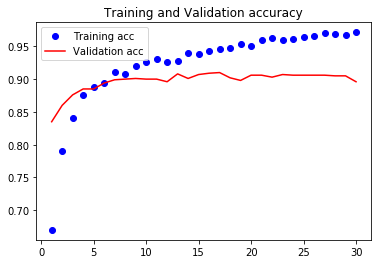

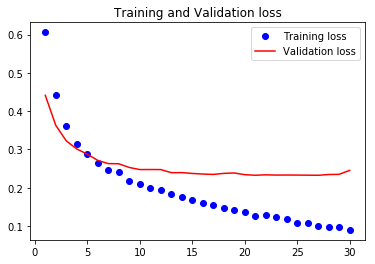

In [15]:
# 绘制训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

# 新加一个图
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

# plt.show() # python2环境下不需要

上面这个方法训练很快，但是无法使用数据增强，且模型很快就过拟合。
现在我们使用第二种方法：扩展卷积基模型，然后端到端训练模型。

In [16]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base) # 将卷积基整个加进来
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### 在编译和训练模型之前，一定要先冻结卷积基。

冻结的目的就是使得训练过程中提取特征的卷积基权重不变。因为全连接层的参数是随机初始化的，训练时在网络中传播的权重更新会很大，如果不把卷积基冻结，卷积基参数会被破坏掉。

**Keras中冻结网络的方法很简单：将其`trainable`属性设置为`False`即可。**

In [18]:
conv_base.trainable = False # 冻结卷积基

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
# 编译训练模型
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc']
             )
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

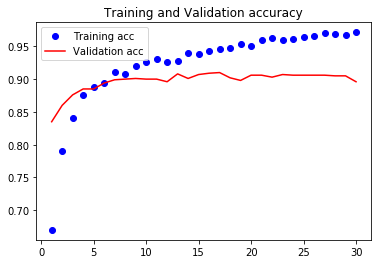

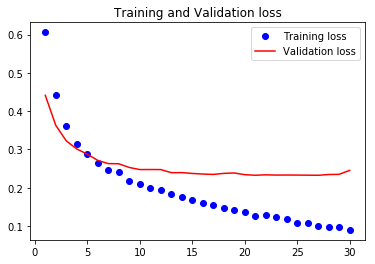

In [26]:
# 绘制训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

# 新加一个图
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### 微调网络

用于特征提取的卷积基是需要被冻结的，而微调则是将顶部的几层解冻，将解冻的几层和新增的部分，如全连接层联合训练。之所以称之为微调，是因为我们只略微调整了复用的模型的更加抽象的表示部分，使得模型与当前求解问题更加相关。

需要注意的是，在微调这里，也需要先将卷积基全部冻结来训练自己的分类器，只有分类器训练完毕后，才能解冻卷积基的顶部几层，进行微调，如果分类器没有训练好，训练期间的传播误差信号很大，待微调的卷积部分会被破坏。

所以，微调的步骤总结如下：

- 在卷积基上（已训练好的网络）添加自定义网络
- 冻结基网络
- 训练所添加的部分
- 解冻基网络的一些层
- 联合训练解冻的层和添加的层



In [27]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [28]:
# 冻结知道某一层的所有层
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1': # 从这一层开始往后均可训练
        set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

In [31]:
# 微调模型
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc']
             )
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)